In [4]:
import torch
from cifar100 import CIFAR100DataModule
import torchvision
import torchvision.transforms as transforms
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

In [5]:
CIFAR = "/media/curttigges/project-files/datasets/cifar-100/"
cifar100 = CIFAR100DataModule(batch_size=256, num_workers=12,data_dir=CIFAR)

In [3]:
train_transforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomResizedCrop(size=[32,32]),
     transforms.ToTensor(),
     cifar10_normalization()]
)

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
    cifar10_normalization()]
)
batch_size = 256

trainset = torchvision.datasets.CIFAR100(root=CIFAR, train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=24)

testset = torchvision.datasets.CIFAR100(root=CIFAR, train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=24)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


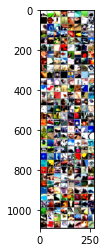

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [6]:
def img_to_patch(x, patch_size):
    '''Transforms image into list of patches of the specified dimensions

    Args:
        x (Tensor): Tensor of dimensions B x C x H x W, representing a batch.
        B=Batch size, C=Channel count.
        patch_size (int): Size of one side of (square) patch.

    Returns:
        patch_seq (Tensor): List of patches of dimension B x N x [C * P ** 2],
        where N is the number of patches and P is patch_size.

    Notes:
        May need to add padding
    '''
    B, C, H, W = x.shape

    # reshape to B x C x H_count x H_patch x W_count x W_patch
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)
    x = x.flatten(1,2)
    x = x.flatten(2, 4)
    
    return x

In [7]:
import pl_bolts
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import MultiStepLR
from torchmetrics.functional import accuracy

In [8]:
class ViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(input_dim)
        self.attn = nn.MultiheadAttention(input_dim, num_heads)
        self.norm2 = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        out = self.norm1(x)
        out, _ = self.attn(out, out, out)
        
        # First residual connection
        resid = x + out

        # Pass through MLP layer
        out = self.norm2(resid)
        out = F.gelu(self.fc1(out))
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop2(out)

        # Second residual connection
        out = out + resid

        return out

In [9]:
class ViTClassifier(pl.LightningModule):
    def __init__(self, embed_size, hidden_size, hidden_class_size, num_encoders, num_heads, patch_size, num_patches, dropout, learning_rate=0.001):
        super().__init__()

        # Key parameters
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.save_hyperparameters()

        # Initial projection of flattened patches into an embedding
        self.input = nn.Linear(3*(patch_size**2), embed_size)
        self.drop = nn.Dropout(dropout)

        # Transformer with arbitrary number of encoders, heads, and hidden size
        self.transformer = nn.Sequential(
            *(ViTEncoder(embed_size, hidden_size, num_heads, dropout) for _ in range(num_encoders))
        )
        
        # Classification head
        self.fc1 = nn.Linear(embed_size, hidden_class_size)
        self.fc2 = nn.Linear(hidden_class_size, 100)

        # Learnable parameters for class and position embedding
        self.class_embed = nn.Parameter(torch.randn(1, 1, embed_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_size))

    def forward(self, x):
        # x will be in the shape B x N x C x P x P
        x = img_to_patch(x, self.patch_size)       

        # pass input through projection layer; shape is B x N x (C * P**2)
        x = F.relu(self.input(x))
        B, N, L = x.shape

        # concatenate class embedding and add positional encoding
        class_embed = self.class_embed.repeat(B, 1, 1)
        x = torch.cat([class_embed, x], dim=1)
        x = x + self.pos_embed[:, :N+1]
        x = self.drop(x)

        # apply transformer
        x = x.transpose(0, 1) # result is N x B x (C * P**2)
        x = self.transformer(x)
        x = x[0] # grab the class embedding
        
        # pass through classification head
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        #preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(y_hat, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
            wandb.log({f"{stage}_loss": loss})
            wandb.log({f"{stage}_acc": acc})
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        wandb.log({"loss": loss})
        return loss

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.03)
        
        steps_per_epoch = 60000 // batch_size
        '''
        lr_scheduler_dict = {
            "scheduler":MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        }
        '''
        lr_scheduler_dict = {
            "scheduler":OneCycleLR(
                optimizer,
                self.hparams.learning_rate,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
                anneal_strategy='cos'
            ),
            "interval":"step",
        }
        return {"optimizer":optimizer, "lr_scheduler":lr_scheduler_dict}

In [10]:
model_kwargs = {
    "embed_size":256, 
    "hidden_size":512,
    "hidden_class_size":512, 
    "num_encoders":24,
    "num_heads":8,
    "patch_size":4,
    "num_patches":64,
    "dropout":0.1,
    "learning_rate":0.001
}


In [11]:
import wandb

wandb.init(
        project="vit-classifier", 
        entity="ascendant",
        config = {
        "batch_size":batch_size,
        "embed_size":model_kwargs["embed_size"], 
        "hidden_size":model_kwargs["hidden_size"],
        "hidden_class_size":model_kwargs["hidden_class_size"], 
        "num_encoders":model_kwargs["num_encoders"],
        "num_heads":model_kwargs["num_heads"],
        "patch_size":model_kwargs["patch_size"],
        "num_patches":model_kwargs["num_patches"],
        "dropout":model_kwargs["dropout"],
        "learning_rate":model_kwargs["learning_rate"],
        "scheduler":"OneCycleLR",
        "loss":"CrossEntropy"
        })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: curt-tigges (ascendant). Use `wandb login --relogin` to force relogin


In [12]:
from pytorch_lightning.callbacks import TQDMProgressBar
pl.seed_everything(42)
model = ViTClassifier(**model_kwargs)
trainer = pl.Trainer(max_epochs=60,accelerator='gpu', devices=1, callbacks=[TQDMProgressBar(refresh_rate=10)])
trainer.fit(model, datamodule=cifar100)
wandb.finish()

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


Global seed set to 42
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | input       | Linear     | 12.5 K
1 | drop        | Dropout    | 0     
2 | transformer | Sequential | 12.7 M
3 | fc1         | Linear     | 131 K 
4 | fc2         | Linear     | 51.3 K
-------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.451    Total estimated model params size (MB)


Epoch 6:  51%|█████     | 100/196 [03:46<03:37,  2.27s/it, loss=3.62, v_num=79, val_loss=3.430, val_acc=0.169] 

/home/curttigges/miniconda3/envs/pytorch-dl/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


loss,█▇▇▆▆▆▄▄▅▄▅▅▄▄▄▄▄▄▃▃▃▄▄▃▂▂▃▃▂▂▂▂▃▂▂▂▁▁▂▂
val_acc,▁▄▃▂▃▃▄▃▄▄▅▄▄▄▄▄▄▄▆▅▆▆▆▆▅▅▅▇▆▆▆██▆▇▇█▆▇▆
val_loss,█▅▅▅▅▅▅▆▄▄▄▄▄▄▃▄▃▃▃▃▂▃▃▂▃▃▃▁▂▂▂▁▁▁▂▂▁▁▂▂
loss,3.50786
val_acc,0.13971
val_loss,3.63377


In [14]:
from data import cifar100

ModuleNotFoundError: No module named 'data'